In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy as pt
from theano import shared
%matplotlib inline
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import regex as re


In [2]:
df = pd.read_csv('../other/frac_merge_peak.csv')


In [3]:
df.columns


Index([u'PropID', u'RSID', u'End_Date', u'Reservoir', u'Completed_Feet',
       u'#_of_Stages', u'Stage_Length', u'Clusters/Stage', u'Cluster_Spacing',
       u'Perfs/Cluster', u'Fluid_Bbls', u'Fluid_Gal/Ft', u'Fluid_Gal/Cluster',
       u'Fluid_Gal/Perf', u'Prop_Lbs', u'Prop_Lbs/Ft', u'Prop_Lbs/Cluster',
       u'Prop_Lbs/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Avg_Rate',
       u'Max_Rate', u'Rate/Ft', u'Rate/Cluster', u'Rate/Perf', u'Avg_Pressure',
       u'Max_Pressure', u'ISIP/Ft', u'5"_SIP/Ft', u'PROPNUM', u'XEC_FIELD',
       u'OPERATOR', u'COUNTY', u'STATE', u'M_LATITUDE', u'M_LONGITUDE',
       u'MAJOR', u'SPUD_DATE', u'FIRST_PROD', u'Wet_Gas_EUR', u'Dry_Gas_EUR',
       u'Oil_EUR', u'NGL_EUR', u'Days_Production', u'OIL_Peak',
       u'OIL_Days_to_Peak'],
      dtype='object')

In [4]:
X = df[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', 
        u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Cluster_Spacing', u'Avg_Pressure', u'Prop_Lbs/Ft', 
        u'Prop_Lbs/Perf', u'Max_Pressure', u'Fluid_Gal/Perf', u'Fluid_Gal/Ft', u'Prop_Lbs/Cluster', 
        u'Fluid_Gal/Cluster']]
y = df[[u'OIL_Peak']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape


(133, 19)

In [12]:
def standardize_2sd(df):
    return (df - df.mean(0)) / (2 * df.std(0))

def standardize_2sd_test(df_test, df_train):
    return (df_test - df_train.mean(0)) / (2 * df_train.std(0))


In [13]:
X_OLS_train = sm.add_constant(standardize_2sd(X_train))
model = sm.OLS(y_train, X_OLS_train)
model = model.fit()
print model.summary()


                            OLS Regression Results                            
Dep. Variable:               OIL_Peak   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     6.851
Date:                Fri, 11 Nov 2016   Prob (F-statistic):           1.14e-11
Time:                        15:07:43   Log-Likelihood:                -881.57
No. Observations:                 133   AIC:                             1803.
Df Residuals:                     113   BIC:                             1861.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               615.9413     17.21

In [14]:
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(X_OLS_train.drop('const', axis=1), y_train)
print 'Train R2: {0}'.format(model.score(X_OLS_train.drop('const', axis=1), y_train))
X_OLS_test = standardize_2sd_test(X_test, X_train)
print 'Test R2: {0}'.format(model.score(X_OLS_test, y_test))


Train R2: 0.53531511995
Test R2: 0.186603706936


In [15]:
lasso = sm.OLS(y_train, X_OLS_train).fit_regularized(alpha=1, L1_wt=1)
lasso.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               OIL_Peak   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     5.827
Date:                Fri, 11 Nov 2016   Prob (F-statistic):           6.67e-10
Time:                        15:07:49   Log-Likelihood:                -887.11
No. Observations:                 133   AIC:                             1814.
Df Residuals:                     113   BIC:                             1872.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               614.9413     17.946     34.266      0.000       579.386   650.496
Clusters/Stage     -290.3043    128.528     -2.259      0.026      -544.942   -35.666
Perfs/Cluster      -394.7479    219.138     -1.801      0.074      -828.900    39.404
#_of_Stages         154.1554     72.917      2.114      0.037         9.695   298.616
ISIP/Ft            -209.6567     72.143     -2.906      0.004      -352.585   -66.729
Rate/Ft              68.6648     83.433      0.823      0.412       -96.631   233.960
Rate/Perf          -139.6013    157.880     -0.884      0.378      -452.389   173.187
Avg_Prop_Conc       -21.0598     64.863     -0.325      0.746      -149.565   107.446
Max_Prop_Conc       -38.8937     42.717     -0.910      0.365      -123.524    45.737
Rate/Cluster       -139.9728    140.368     -0.997      0.321      -418.067   138.122
Max_Rate            154.5035     91.257      1.693      0.093       -26.293   335.300
Cluster_Spacing            0          0        nan        nan             0         0
Avg_Pressure        222.7534     73.748      3.020      0.003        76.646   368.861
Prop_Lbs/Ft                0          0        nan        nan             0         0
Prop_Lbs/Perf              0          0        nan        nan             0         0
Max_Pressure        -71.3550     52.018     -1.372      0.173      -174.412    31.702
Fluid_Gal/Perf     -157.3745    122.685     -1.283      0.202      -400.435    85.686
Fluid_Gal/Ft               0          0        nan        nan             0         0
Prop_Lbs/Cluster           0          0        nan        nan             0         0
Fluid_Gal/Cluster          0          0        nan        nan             0         0
==============================================================================
Omnibus:                       30.746   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.093
Skew:                           0.980   Prob(JB):                     1.99e-14
Kurtosis:                       5.747   Cond. No.                         89.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
X_lasso_train = X_train[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_train_std = standardize_2sd(X_lasso_train)
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(X_lasso_train_std, y_train)
print 'Train R2: {0}'.format(model.score(X_lasso_train_std, y_train))
X_lasso_test = X_test[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_test_std = standardize_2sd_test(X_lasso_test, X_lasso_train)
print 'Test R2: {0}'.format(model.score(X_lasso_test_std, y_test))


Train R2: 0.506618464039
Test R2: 0.188315827225


In [23]:
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
        
def create_smry(trc, dfs, pname='mfr'):
    ''' Conv fn: create trace summary for sorted forestplot '''

    dfsm = pm.df_summary(trc).reset_index()
    dfsm.rename(columns={'index':'featval'}, inplace=True)
    dfsm = dfsm.loc[dfsm['featval'].apply(
        lambda x: re.search('{}__[0-9]+'.format(pname), x) is not None)]

    dfsm.set_index(dfs[pname].unique(), inplace=True)
    dfsm.sort('mean', ascending=True, inplace=True)
    dfsm['ypos'] = np.arange(len(dfsm))
    
    return dfsm
        
def custom_forestplot(df, ylabel='field', size=8, aspect=0.8, facetby=None):
    ''' Conv fn: plot features from pm.df_summary using seaborn
        Facet on sets of forests for comparison '''
        
    g = sns.FacetGrid(col=facetby, hue='mean', data=df, palette='RdBu_r'
                      ,size=size, aspect=aspect)
    _ = g.map(plt.scatter, 'mean', 'ypos'
                ,marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10)
    _ = g.map(plt.hlines, 'ypos', 'hpd_2.5','hpd_97.5', color='#aaaaaa')

    _ = g.axes.flat[0].set_ylabel(ylabel)
    _ = [ax.set_xlabel('coeff value') for ax in g.axes.flat]
    _ = g.axes.flat[0].set_ylim((-1, df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticks(np.arange(df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticklabels(df.index)
    

In [20]:
run_pooled = True

In [21]:
data = dict(x=X_lasso_train_std, y=y_train)

with pm.Model() as mdl_pooled:
    pm.glm.glm('y ~ x', data, family=pm.glm.families.Normal())
    if run_pooled:
        trc_pooled = pm.backends.text.load('../other/traces_txt/trc_pooled')
    else:
        step = pm.NUTS()
        start = pm.find_MAP()
        trace = pm.backends.Text('../other/traces_txt/trc_pooled')
        trc_pooled = pm.sample(2000, njobs=1, step=step, start=start, trace=trace)    
    

Applied log-transform to sd and added transformed sd_log_ to model.
INFO:pymc3:Applied log-transform to sd and added transformed sd_log_ to model.


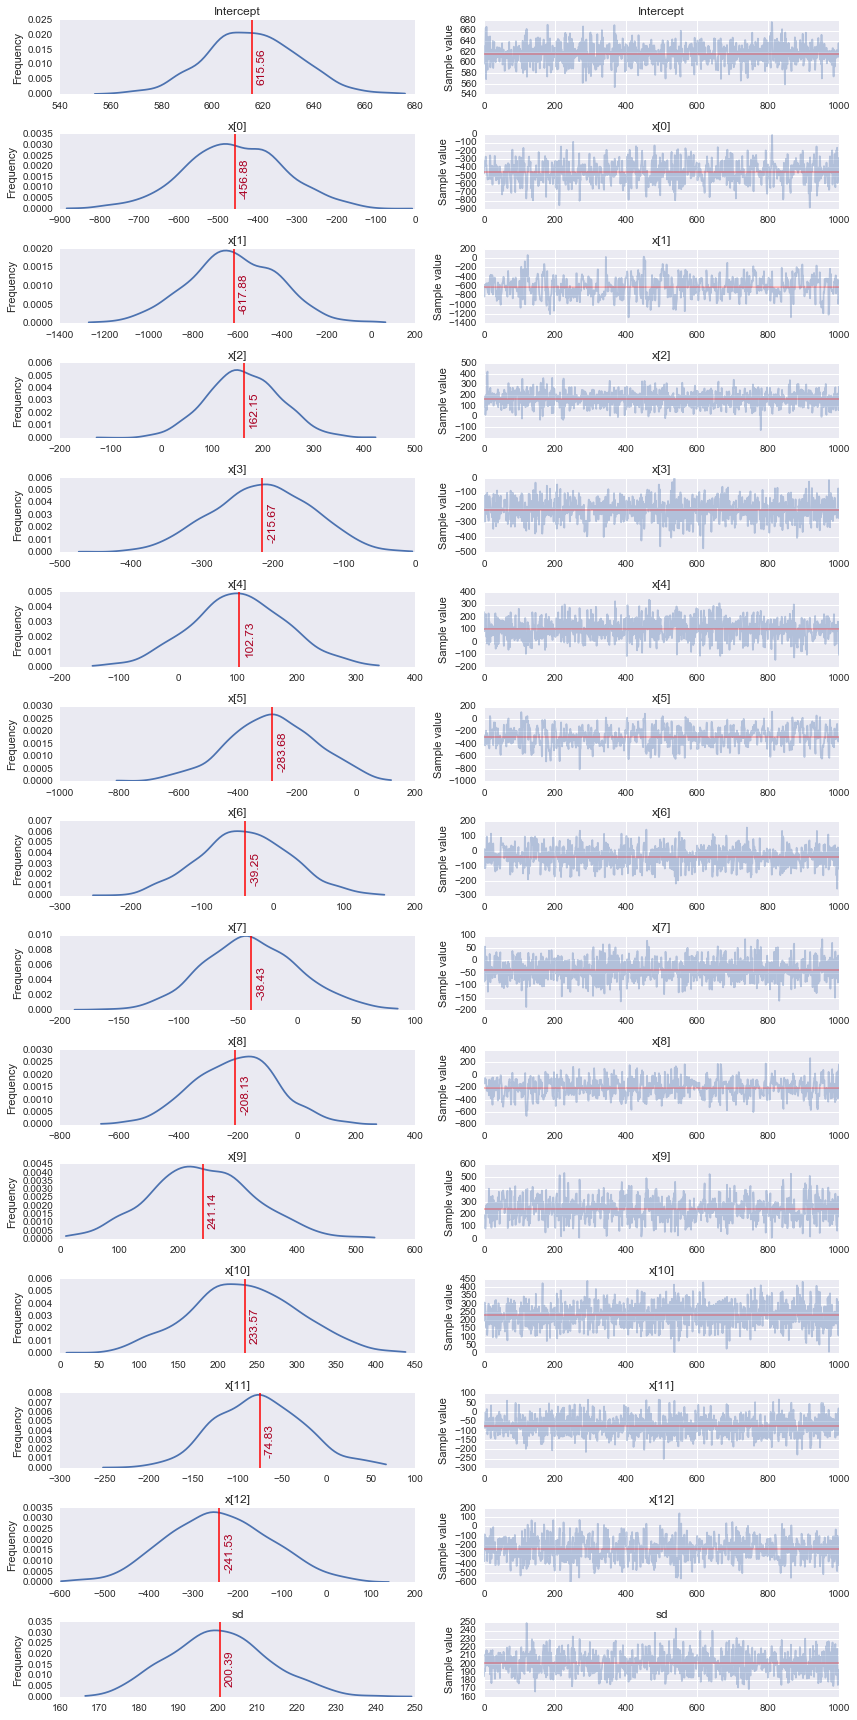

In [24]:
plot_traces(trc_pooled, retain=1000)


In [25]:
pm.df_summary(trc_pooled[-1000:])


,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,615.556979,18.422715,0.571114,579.553001,651.162451
x[0],-456.878708,125.837688,5.331533,-682.630181,-185.286957
x[1],-617.878500,206.651375,10.578001,-1023.913370,-237.567767
x[2],162.151039,71.912031,2.199659,31.893312,306.325930
x[3],-215.668699,70.746106,2.404054,-354.978286,-86.030621
x[4],102.729921,80.449771,2.669005,-49.543525,266.405664
x[5],-283.677622,147.340869,7.530281,-562.916912,8.554279
x[6],-39.249234,63.240693,2.538733,-177.713890,71.797831
x[7],-38.430143,40.746409,1.178745,-118.219088,39.234025
x[8],-208.131234,141.322192,6.219597,-489.987392,49.372779


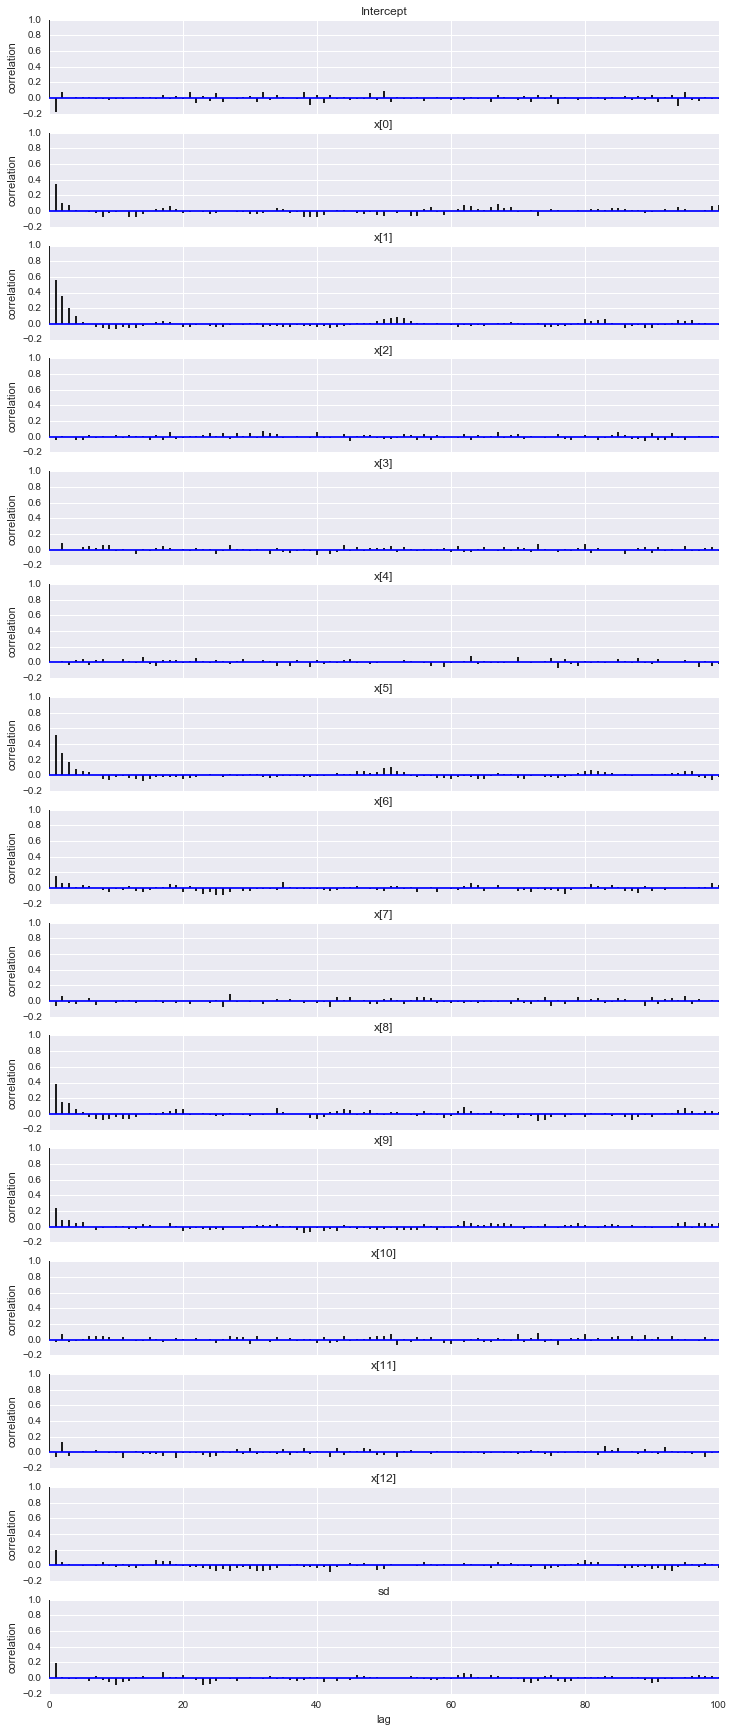

In [26]:
ax = pm.autocorrplot(trc_pooled[-1000:])


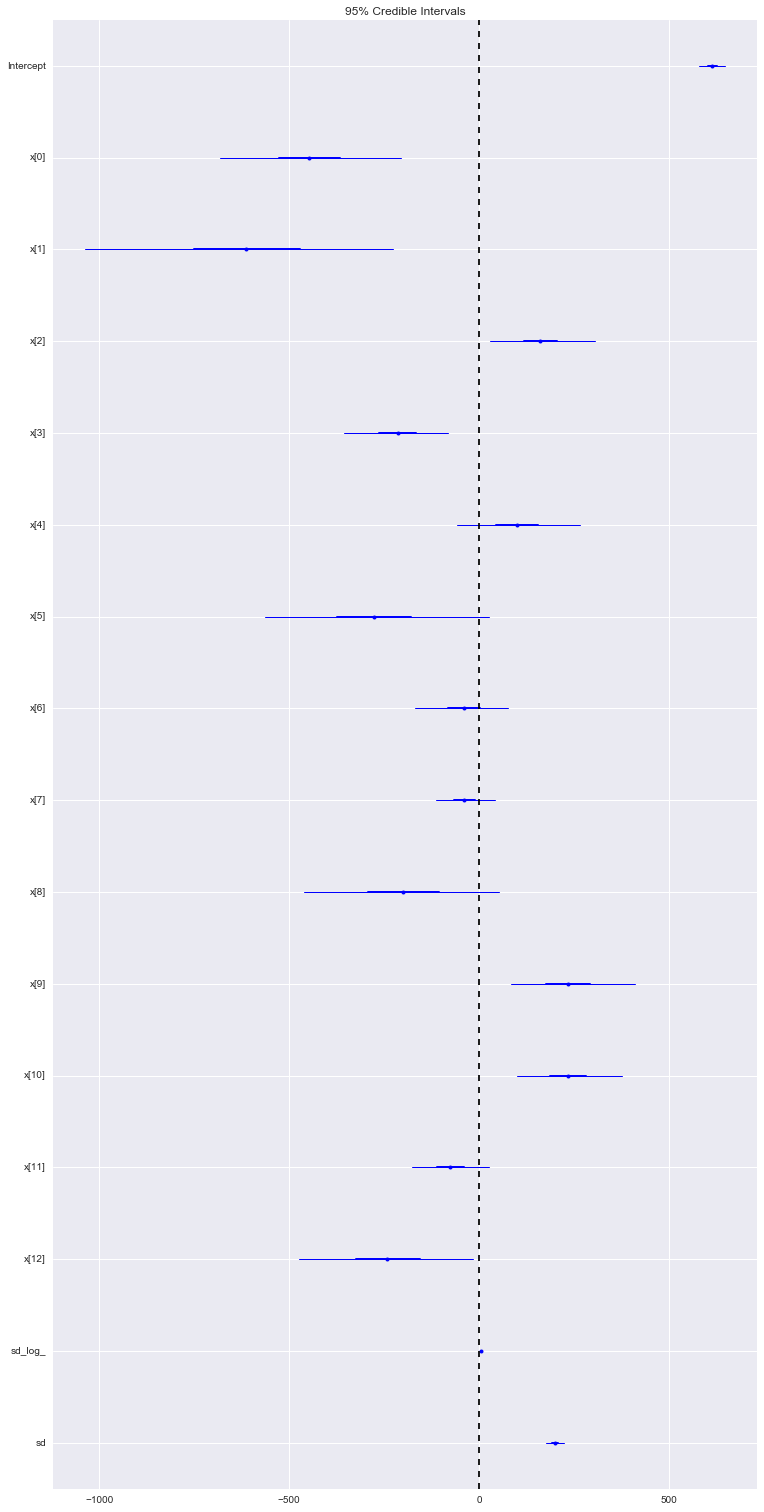

In [27]:
plt.figure(figsize=(12, 24))
pm.forestplot(trc_pooled)
# plt.savefig('../../Downloads/forestplot.png', dpi=400)
# plt.xlim(-1000, 1000)


In [28]:
ppc_pooled = pm.sample_ppc(trc_pooled[-1000:], samples=500, model=mdl_pooled, size=50)
y_pred1 = ppc_pooled['y'].mean(0).mean(0).T
waic_pooled = pm.stats.waic(model=mdl_pooled, trace=trc_pooled[-1000:])
print 'Train_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_train, y_pred1)))
print 'Train_R2: {0}'.format(r2_score(y_train, y_pred1))
print 'Train_WAIC: {0}'.format(waic_pooled)


Train_RMSE: 188.56181209
Train_R2: 0.506537112487
Train_WAIC: 1806.96252333


//anaconda/lib/python2.7/site-packages/pymc3/stats.py:138: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


(0, 1200)

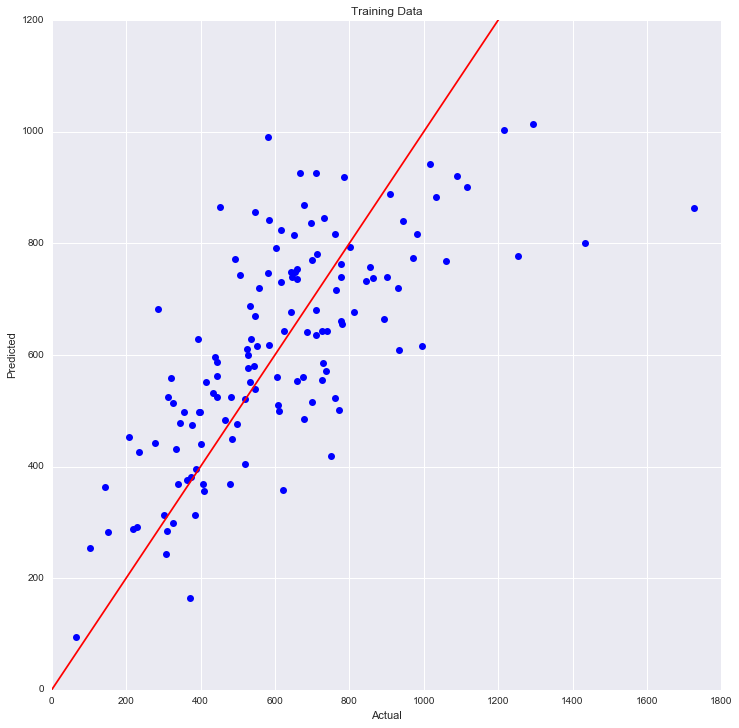

In [29]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_train, y_pred1, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_title('Training Data')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])



In [30]:
parm_pooled = pm.df_summary(trc_pooled[-1000:]).values

In [31]:
y_pred2 = parm_pooled[0,0] + np.dot(X_lasso_train_std.values, parm_pooled[1:-1,0])

(0, 1200)

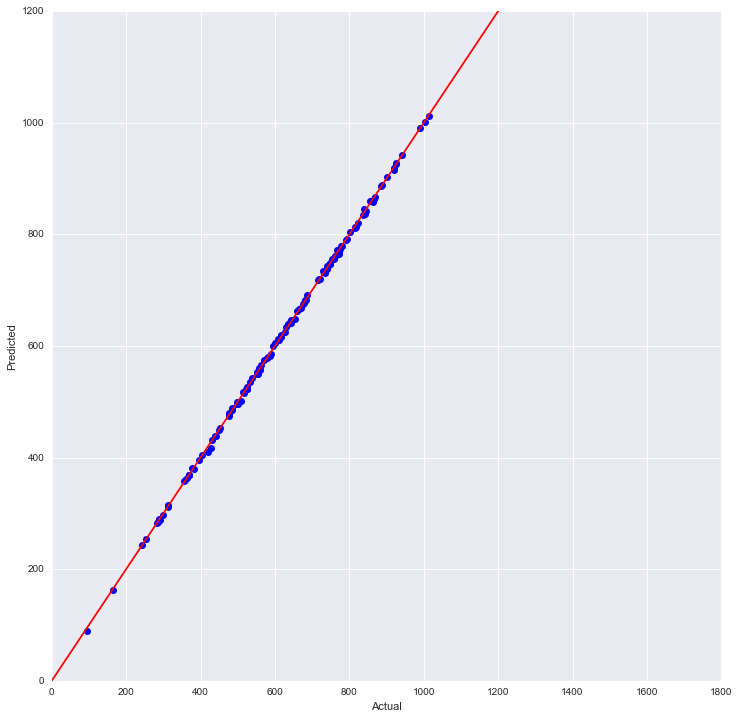

In [32]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_pred1, y_pred2, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])

In [33]:
y_pred_test = parm_pooled[0,0] + np.dot(X_lasso_test_std.values, parm_pooled[1:-1,0])

In [34]:
print 'Test_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print 'Test_R2: {0}'.format(r2_score(y_test, y_pred_test))

Test_RMSE: 199.638940639
Test_R2: 0.180450879786


(0, 1200)

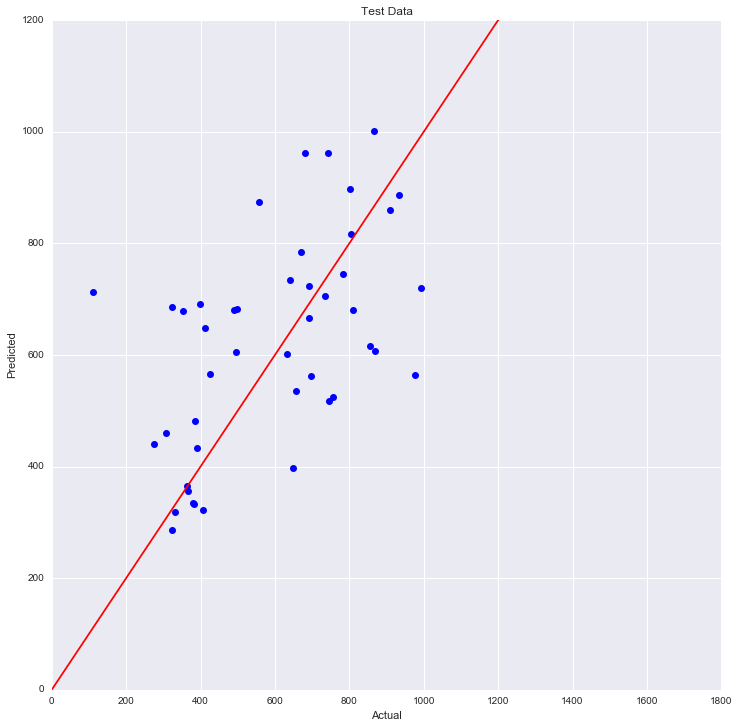

In [35]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_test, y_pred_test, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_title('Test Data')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])

Form Patsy dmatrices to test explicit model

In [78]:
fts_num = [u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']
ft_endog = u'OIL_Peak'

In [77]:
dfs = pd.concat((y_train, standardize_2sd(X_train[fts_num])),1)

In [83]:
dfs.columns

Index([u'OIL_Peak', u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages',
       u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc',
       u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure',
       u'Max_Pressure', u'Fluid_Gal/Perf'],
      dtype='object')

In [87]:
#Rename Clusters/Stage, Perfs/Cluster, #_of_Stages, ISIP/Ft, Rate/Ft, Rate/Perf, Rate/Cluster, Fluid_Gal/Perf

In [91]:
dfs.columns = [u'OIL_Peak', u'Clusters_Stage', u'Perfs_Cluster', u'Num_of_Stages',
       u'ISIP_Ft', u'Rate_Ft', u'Rate_Perf', u'Avg_Prop_Conc',
       u'Max_Prop_Conc', u'Rate_Cluster', u'Max_Rate', u'Avg_Pressure',
       u'Max_Pressure', u'Fluid_Gal_Perf']

In [94]:
fts_num = [u'Clusters_Stage', u'Perfs_Cluster', u'Num_of_Stages', u'ISIP_Ft', u'Rate_Ft', u'Rate_Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate_Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal_Perf']

In [95]:
fml_pooled = '{} ~ '.format(ft_endog) + ' + '.join(fts_num)
print(fml_pooled)

OIL_Peak ~ Clusters_Stage + Perfs_Cluster + Num_of_Stages + ISIP_Ft + Rate_Ft + Rate_Perf + Avg_Prop_Conc + Max_Prop_Conc + Rate_Cluster + Max_Rate + Avg_Pressure + Max_Pressure + Fluid_Gal_Perf


In [98]:
(y_unpooled, x_unpooled) = pt.dmatrices(fml_pooled, dfs , return_type='dataframe', NA_action='raise')
x_unpooled.head()

,Intercept,Clusters_Stage,Perfs_Cluster,Num_of_Stages,ISIP_Ft,Rate_Ft,Rate_Perf,Avg_Prop_Conc,Max_Prop_Conc,Rate_Cluster,Max_Rate,Avg_Pressure,Max_Pressure,Fluid_Gal_Perf
2,1.0,-0.093921,1.029228,-0.647502,0.070073,-0.724103,-0.962975,-0.774617,-0.032683,0.202250,0.353341,-0.624155,0.301898,-1.163110
100,1.0,-0.093921,-0.300421,-0.127153,-0.233839,0.287866,0.516244,-0.191008,-0.305783,0.009429,0.221334,0.143933,-0.388353,0.555574
122,1.0,0.473872,-0.256099,0.002934,-0.537750,-0.133788,0.120024,-0.019359,0.064040,-0.242196,0.287337,-0.466678,-0.536005,0.141536
154,1.0,0.473872,-0.189617,0.436559,-0.765683,0.625189,0.014366,0.529919,-0.174923,-0.171085,0.492683,-0.319161,0.440821,-0.306347
51,1.0,-0.093921,-0.300421,-0.213878,0.298006,-0.133788,0.031976,0.941878,0.109557,-0.443223,-1.201417,-0.064584,-0.529459,-0.207390


In [103]:
with pm.Model() as mdl_test:
   
    # define priors, use Normal
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1_Clusters/Stage', mu=0, sd=100)
    b2 = pm.Normal('b2_Perfs/Cluster', mu=0, sd=100)
    b3 = pm.Normal('b3_#_of_Stages', mu=0, sd=100)
    b4 = pm.Normal('b4_ISIP/Ft', mu=0, sd=100)
    b5 = pm.Normal('b5_Rate/Ft', mu=0, sd=100)
    b6 = pm.Normal('b6_Rate/Perf', mu=0, sd=100)
    b7 = pm.Normal('b7_Avg_Prop_Conc', mu=0, sd=100)
    b8 = pm.Normal('b8_Max_Prop_Conc', mu=0, sd=100)
    b9 = pm.Normal('b9_Rate/Cluster', mu=0, sd=100)
    b10 = pm.Normal('b10_Max_Rate', mu=0, sd=100)
    b11 = pm.Normal('b11_Avg_Pressure', mu=0, sd=100)
    b12 = pm.Normal('b12_Max_Pressure', mu=0, sd=100)    
    b13 = pm.Normal('b13_Fluid_Gal/Perf', mu=0, sd=100)    
    
    # define linear model
    y =    ( b0 +
             b1 * x_unpooled['Clusters_Stage'] + 
             b2 * x_unpooled['Perfs_Cluster'] +
             b3 * x_unpooled['Num_of_Stages'] +
             b4 * x_unpooled['ISIP_Ft'] +
             b5 * x_unpooled['Rate_Ft'] +
             b6 * x_unpooled['Rate_Perf'] +
             b7 * x_unpooled['Avg_Prop_Conc'] +
             b8 * x_unpooled['Max_Prop_Conc'] +
             b9 * x_unpooled['Rate_Cluster'] +
             b10 * x_unpooled['Max_Rate'] +
             b11 * x_unpooled['Avg_Pressure'] +
             b12 * x_unpooled['Max_Pressure'] +
             b13 * x_unpooled['Fluid_Gal_Perf'])

    ## Likelihood (sampling distribution) of observations
    epsilon = pm.HalfCauchy('epsilon', beta=10)
    likelihood = pm.Normal('likelihood', mu=y, sd=epsilon, observed=dfs[ft_endog])
 
    step = pm.NUTS()
    start = pm.find_MAP()
    trc_test = pm.sample(2000, step, start, progressbar=True)

Applied log-transform to epsilon and added transformed epsilon_log_ to model.
INFO:pymc3:Applied log-transform to epsilon and added transformed epsilon_log_ to model.
100%|██████████| 2000/2000 [00:07<00:00, 253.50it/s]


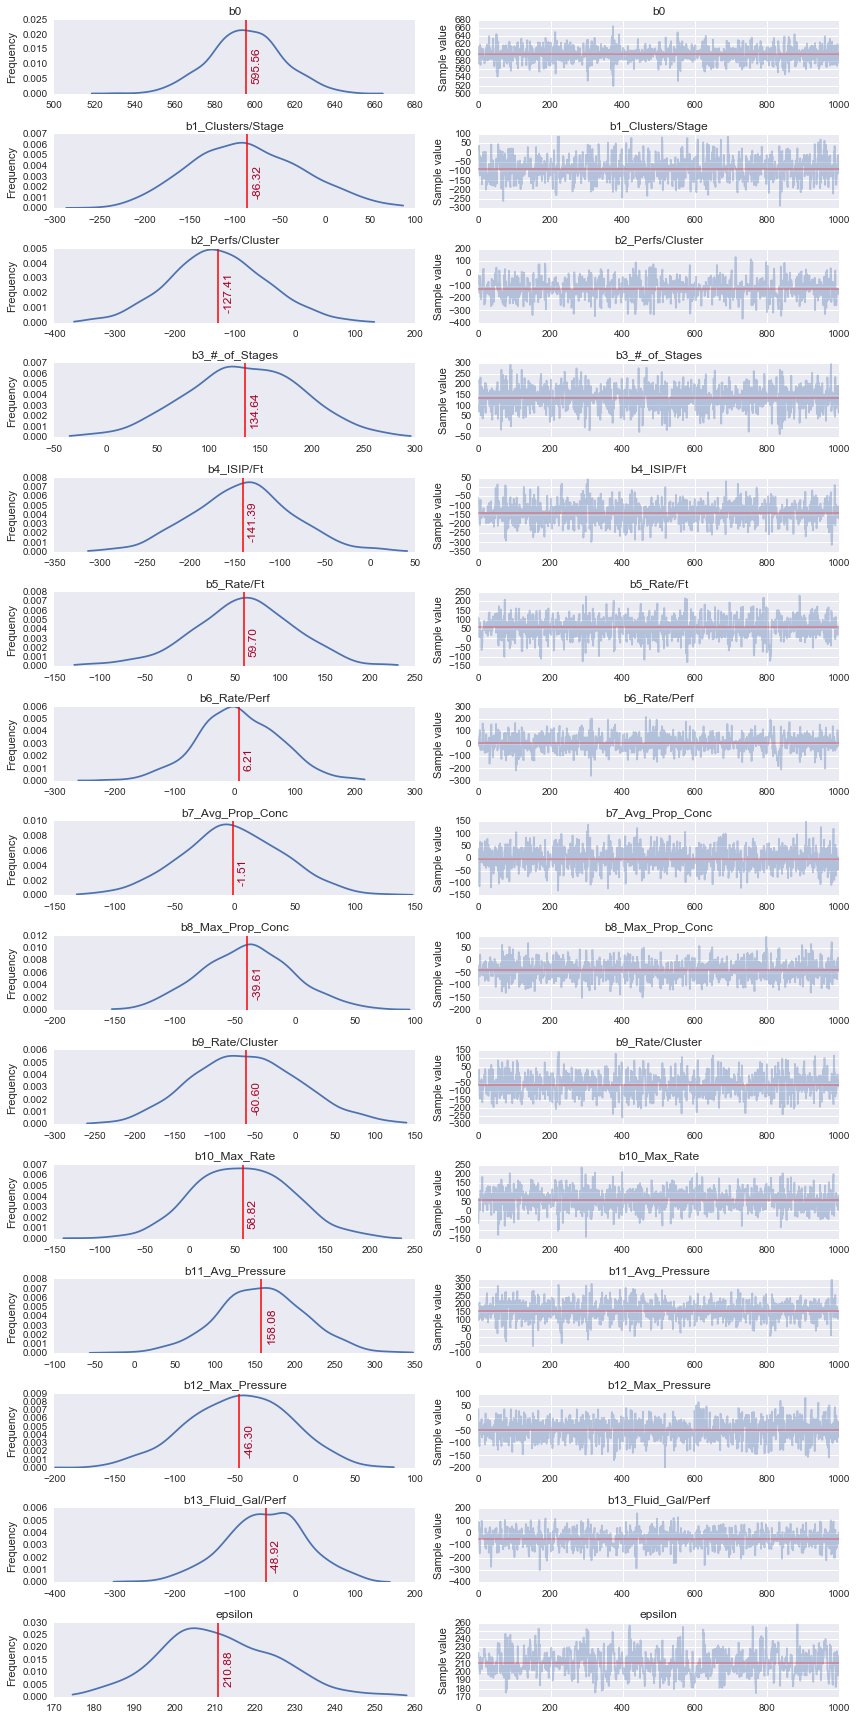

In [104]:
# rvs_test = [rv.name for rv in mdl_test.unobserved_RVs]
# ax = pm.traceplot(trc_test[-500:], varnames=rvs_test, figsize=(12,len(rvs_test)*1.4), combined=False)
plot_traces(trc_test, retain=1000)


In [105]:
pm.df_summary(trc_test[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0,595.556005,18.566520,0.450872,559.210766,631.511362
b1_Clusters/Stage,-86.318863,62.855518,2.003912,-205.166816,35.270297
b2_Perfs/Cluster,-127.408301,81.545134,2.996943,-278.797359,38.245260
b3_#_of_Stages,134.636144,56.303495,1.568342,30.594664,247.201390
b4_ISIP/Ft,-141.391059,55.789783,1.716904,-245.757952,-29.660614
b5_Rate/Ft,59.696895,57.214855,1.751106,-54.885700,169.327876
b6_Rate/Perf,6.214080,68.300019,2.692463,-128.184346,141.397246
b7_Avg_Prop_Conc,-1.506395,42.668446,1.226532,-80.963163,83.509479
b8_Max_Prop_Conc,-39.612892,38.191367,1.042120,-114.036245,33.589614
b9_Rate/Cluster,-60.601694,67.562707,2.209856,-188.278664,75.333904


In [106]:
def coeff(trace, model):
    coeff = pd.DataFrame()
    for name in [rv.name for rv in model.unobserved_RVs[:-2]]:
        coeff = pd.concat((coeff, pd.Series(trace[-500:][name])), axis=1)
    coeff.columns = [rv.name for rv in model.unobserved_RVs[:-2]]
    return coeff

In [107]:
df_coeff_pooled = coeff(trc_pooled, mdl_pooled)
df_coeff_pooled.mean()

Intercept    616.057993
x[0]        -447.806413
x[1]        -602.713206
x[2]         158.923390
x[3]        -218.808881
x[4]         102.952802
x[5]        -273.094724
x[6]         -40.778961
x[7]         -37.389610
x[8]        -206.924094
x[9]         237.705987
x[10]        237.053380
x[11]        -76.671845
x[12]       -241.277671
dtype: float64

In [108]:
df_coeff_test = coeff(trc_test, mdl_test)
df_coeff_test.mean()

b0                    594.979077
b1_Clusters/Stage     -86.451130
b2_Perfs/Cluster     -126.927627
b3_#_of_Stages        133.897056
b4_ISIP/Ft           -139.210988
b5_Rate/Ft             61.608231
b6_Rate/Perf            6.378204
b7_Avg_Prop_Conc       -1.885140
b8_Max_Prop_Conc      -38.916428
b9_Rate/Cluster       -60.035641
b10_Max_Rate           57.282802
b11_Avg_Pressure      156.845517
b12_Max_Pressure      -46.214065
b13_Fluid_Gal/Perf    -48.707004
dtype: float64

In [110]:
ppc_test = pm.sample_ppc(trc_test[-500:], samples=500, model=mdl_test, size=50)
y_pred3 = ppc_test['likelihood'].mean(0).mean(0).T
waic_test = pm.stats.waic(model=mdl_test, trace=trc_test[-500:])
print 'Train_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_train, y_pred3)))
print 'Train_R2: {0}'.format(r2_score(y_train, y_pred3))
print 'Train_WAIC: {0}'.format(waic_test)


Train_RMSE: 202.270495648
Train_R2: 0.432178167721
Train_WAIC: 1814.34989458


(0, 1200)

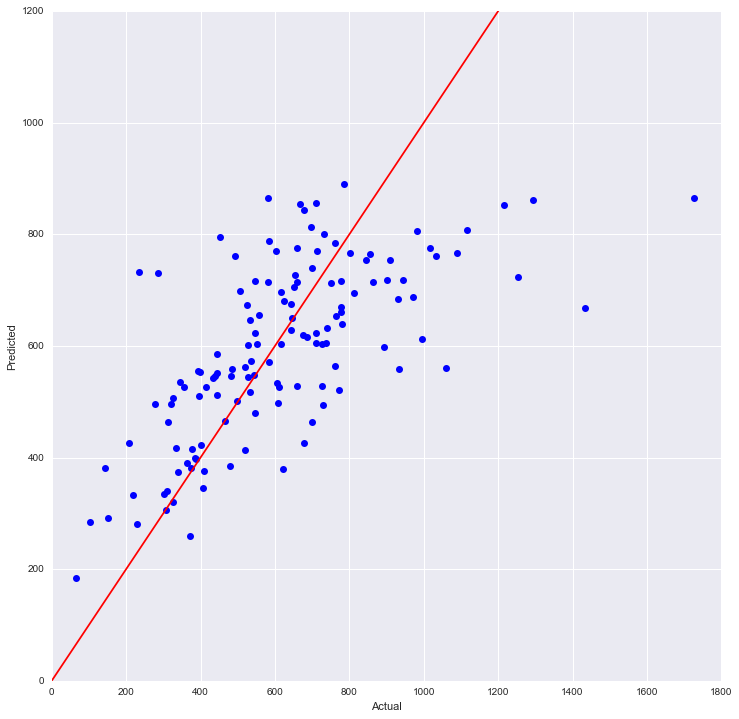

In [112]:
y_pred = ppc_test['likelihood'].mean(0).mean(0).T
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_train, y_pred3, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])

In [119]:
parm_test = pm.df_summary(trc_test[-500:]).values
y_pred_test = parm_test[0,0] + np.dot(X_lasso_test_std.values, parm_test[1:-1,0])
print 'Test_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print 'Test_R2: {0}'.format(r2_score(y_test, y_pred_test))

Test_RMSE: 164.850581327
Test_R2: 0.441188363645


(0, 1200)

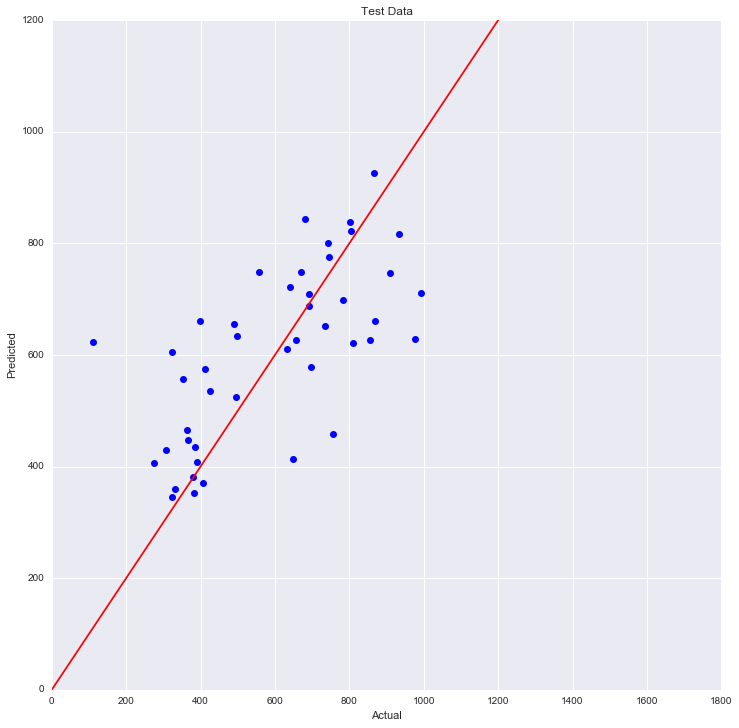

In [120]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_test, y_pred_test, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_title('Test Data')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])